# Scrape https://www.wicprograms.org/

First we scrape the state names from "https://www.wicprograms.org/" to create a list of urls to scrape.

In [227]:
import requests
from bs4 import BeautifulSoup
import re
from uszipcode import SearchEngine


URL = "https://www.wicprograms.org/"
r = requests.get(URL)
soup = BeautifulSoup(r.content, 'html5lib')

states = [option for option in soup.find_all('select')[0].find_all('option')][1:]
states = [s.get('value') for s in states]

## Use wayback machine to get change history of the WIC clinincs at the state level

In [ ]:
! wayback-machine-scraper -a 'https://www.wicprograms.org/$' https://www.wicprograms.org/ -o './data/'

This creates the following directory structure in `./data/`:

```
website/
└── www.wicprograms.org
       ├── 20101203122320.snapshot
       ├── 20110202214735.snapshot
       ...
       └── 20220119003812.snapshot
```

Im goint to ignore the snapshots that are older than Jun 21 2012 since they do not contain the table of WIC clinics by state.

In [2]:
from os import listdir
from os.path import isfile, join

data_path = './data/www.wicprograms.org/'

snapshots = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f.endswith('.snapshot')]

snapshots = [s for s in snapshots if int(s[:14]) > 20120620000000 ]

In [15]:
from bs4 import BeautifulSoup
import pandas as pd
import re

problem = []
WIC_count_by_state = pd.DataFrame({'state': [], 'WIC_count': [], 'snapshot': []})
for i in range(len(snapshots)):
    with open(data_path + snapshots[i]) as fp:
        soup = BeautifulSoup(fp, 'html.parser')
    state_data = {'state': [], 'WIC_count': [], 'snapshot': []}
    try:
        table = soup.find_all('div', {'class':"multicolumn"})[0]
    except:
        table = soup.find_all("ul", {'class':"statelist"})[0]
    statte_list = table.find_all('a')
    state_data['state'] = [s.text for s in statte_list]

    program_count = table.find_all('em')
    state_data['WIC_count'] = [int("".join(filter(str.isdigit, p.text))) for p in program_count]
    state_data['snapshot'] = pd.to_datetime([snapshots[i][:-9]]*len(state_data['state']))
    state_data = pd.DataFrame(state_data)
    WIC_count_by_state = pd.concat([WIC_count_by_state, state_data], ignore_index=True)

In [28]:
pivot_table = WIC_count_by_state.pivot_table(index='snapshot', columns='state', values='WIC_count').reset_index()

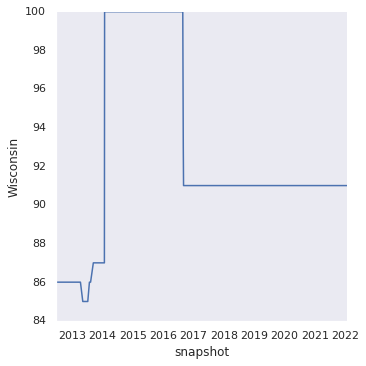

In [35]:
import seaborn as sns
sns.set_theme(style="dark")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=pivot_table, kind='line',
    x="snapshot", y="Wisconsin", facet_kws=dict(sharex=False),
)

We can track the changes in the number of WIC clinics by state:

## Use Wayback Machine to get the all versions of each state's page

In [135]:
import os

# for state in states:
#     os.system(f"wayback-machine-scraper -a 'https://www.wicprograms.org/state/{state}$' https://www.wicprograms.org/state/{state} -o './data/'")

This creates the following directory structure in `./data/`:

```
website/
└── www.wicprograms.org
    └── state
    |   └──alabama
    |       ├── 20110518012524.snapshot
    |       ├── 20110728175734.snapshot
    |       ...
    |       └── 20210508013023.snapshot
    ...
    |   └──wyoming
    |       ├── 20110518012524.snapshot
    |       ├── 20110728175734.snapshot
    |       ...
    |       └── 20210508013023.snapshot
```

**Note:** The this took 30 minutes to run.

Now I will try to scrape the data from one state: `alabama`.

In [52]:
state = 'alabama'
snapshots = [f for f in listdir(data_path+'state/'+state) if isfile(join(data_path+'state/'+state, f))]# and f.endswith('.snapshot')]

snapshots = [s for s in snapshots if int(s[:14]) > 20120620000000 ]

In [131]:
state_data = {'city': [], 'WIC_count': [], 'snapshot': []}
problem = []
for i in range(len(snapshots)):
    with open(data_path+'state/'+state +'/'+ snapshots[i]) as fp:
        soup = BeautifulSoup(fp, 'html.parser')
    snapshot = pd.to_datetime(snapshots[i][:-9])
    table_opt_1 = soup.find_all("div", {"class":"widget"})
    table_opt_2 = soup.find_all("ul", {"class":"statelist"})
    table_opt_3 = soup.find_all("ul", {"class":"unstyled columns_3","id":"cityList"})
    if len(table_opt_1) > 0:
        table = table_opt_1[2]
    elif len(table_opt_2) > 0:
        table = table_opt_2[0]
    elif len(table_opt_3) > 0:
        table = table_opt_3[0]
    try:
        cities = table.find_all('a')
        for city in cities: 
            city_name, city_count = city.text.split("(")
            city_name = city_name.strip()
            city_count = int("".join(filter(str.isdigit, city_count)))
            state_data['city'].append(city_name)
            state_data['WIC_count'].append(city_count)
            state_data['snapshot'].append(snapshot)
    except:
        cities = table.find_all('li')
        for city in cities: 
            _,  city_name, city_count, _ = city.text.split("\n")
            city_name = city_name.strip()
            city_count = int("".join(filter(str.isdigit, city_count)))
            state_data['city'].append(city_name)
            state_data['WIC_count'].append(city_count)
            state_data['snapshot'].append(snapshot)

alabama_data = pd.DataFrame(state_data)

In [132]:
alabama_data

,city,WIC_count,snapshot
0,Abbeville,1,2015-10-27 01:01:11
1,Alexander City,1,2015-10-27 01:01:11
2,Andalusia,1,2015-10-27 01:01:11
3,Ashville,1,2015-10-27 01:01:11
4,Athens,1,2015-10-27 01:01:11
...,...,...,...
1524,Tuskegee,1,2017-06-06 17:16:14
1525,Tyler,1,2017-06-06 17:16:14
1526,Union Springs,1,2017-06-06 17:16:14
1527,Valley,1,2017-06-06 17:16:14


### Going Deeper
We can go even deeper and scrape the data from the individual city pages.

Take for example the page for Abbeville, Alabama:

The link is `https://www.wicprograms.org/ci/al-abbeville`

So we just need city names and state two letter codes.

We can automate this using the city names from the previous step.

In [139]:
for city in alabama_data.city.apply(lambda x: x.lower()).unique():
    os.system(f"wayback-machine-scraper -a 'https://www.wicprograms.org/ci/al-{city}$' https://www.wicprograms.org/ci/al-{city} -o './data/'")

This creates the following directory structure in `./data/`:

```
website/
└── www.wicprograms.org
    └── ci
    |   └──al-abbeville
    |       ├── 20140830153503.snapshot
    |       ├── 20150421212601.snapshot
    |       ...
    |       └── 20170812175844.snapshot
    ...
    |   └──al-wetumpka
    |       ├── 20110518012524.snapshot
    |       ├── 20110728175734.snapshot
    |       ...
    |       └── 20210508013023.snapshot
```

In [233]:
sr = SearchEngine()

state = 'al'
city_list = listdir(data_path+'ci/')
city_list = [c[3:] for c in city_list if c.startswith(state)]
path = data_path+'ci/'+state+'-'
for city in city_list:
    path_city = path+city
    snapshots = [f for f in listdir(path_city) if isfile(join(path_city, f)) and f.endswith('.snapshot')]
    snapshots = [s for s in snapshots if int(s[:14]) > 20120620000000]
    

In [239]:
city = city_list[2]
path_city = path+city
snapshots = [f for f in listdir(path_city) if isfile(join(path_city, f)) and f.endswith('.snapshot')]
snapshots = [s for s in snapshots if int(s[:14]) > 20120620000000]
snapshot = snapshots[0]
city_data = {'city': [], 'address': [], 'snapshot': [], 'telephone': [], 'zip_code': [], 'county': []}
for i in range(len(snapshots)):
        with open(path_city + '/' + snapshots[i]) as fp:
                soup = BeautifulSoup(fp, 'html.parser')
        clinics =  soup.find_all('p', {"style":'font-weight:bold;'})
        for clinic in clinics:
                clinic_data = clinic.text.strip().split("\n")
                if len(clinic_data) == 3:
                        city_data['city'].append(city)
                        clinic_data=[d.strip() for d in clinic_data]
                        address = ", ".join(clinic_data[:2])
                        city_data["address"].append(address)
                        city_data["telephone"] = clinic_data[2]
                        zip_code = re.findall(r"(?<!\d)\d{5}(?!\d)", address)[0]
                        city_data["zip_code"].append(zip_code)
                        city_data["county"] .append(sr.by_zipcode(zip_code).county)
                        city_data["snapshot"].append(pd.to_datetime(snapshot[:-9]))

pd.DataFrame(city_data)

,city,address,snapshot,telephone,zip_code,county
0,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
1,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
2,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
3,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
4,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
5,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County
6,abbeville,"505 Kirkland Street, Abbeville, AL - 36310",2014-08-30 15:35:03,(334) 585-2660,36310,Henry County


**Note:** I used the `uszipcode` package to get the county but the pacage has much more to offer:

## EDIT!!!! 

I realized that there is a county-view of the information stored in the website.

In [179]:
! wayback-machine-scraper -a 'https://www.wicprograms.org/co/al-henry/' https://www.wicprograms.org/co/al-henry -o './data2/'

2022-02-07 17:35:07 [scrapy.utils.log] INFO: Scrapy 2.5.1 started (bot: scrapybot)
2022-02-07 17:35:07 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.1.0, Python 3.8.8 (default, Apr 13 2021, 19:58:26) - [GCC 7.3.0], pyOpenSSL 20.0.1 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.10
2022-02-07 17:35:07 [scrapy.crawler] INFO: Overridden settings:
{'AUTOTHROTTLE_ENABLED': True,
 'AUTOTHROTTLE_START_DELAY': 1,
 'AUTOTHROTTLE_TARGET_CONCURRENCY': 10.0,
 'LOG_LEVEL': 'INFO',
 'USER_AGENT': 'Wayback Machine Scraper/1.0.8 '
               '(+https://github.com/sangaline/scrapy-wayback-machine)'}
2022-02-07 17:35:07 [scrapy.extensions.telnet] INFO: Telnet Password: c31b665c8c38616c
2022-02-07 17:35:07 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.m